# Objetivo do Projeto

- Desenvolver um modelo de Classificação capaz de prever se um cliente vai entrar em churn ou não.

- Etapas do Projeto:
    - Coleta de Dados
    - Análise Descritiva dos Dados
    - Análise Exploratória de Dados
    - Limpeza de Dados
    - Feature Engineering
    - Modelagem de Dados
    - Treinamento de Modelos
    - Avaliação de Modelos
    - Registro MLFLOW
    - Calcular ROI do Projeto
    - Construção de uma API

| Coluna             | Descrição                                                                 |
|--------------------|---------------------------------------------------------------------------|
| `RowNumber`        | Número da linha (apenas um índice)                                        |
| `CustomerId`       | ID único do cliente                                                       |
| `Surname`          | Sobrenome do cliente                                                      |
| `CreditScore`      | Pontuação de crédito (quanto maior, melhor o perfil de crédito)           |
| `Geography`        | País de origem do cliente (`France`, `Spain`, `Germany`)                  |
| `Gender`           | Gênero (`Male`/`Female`)                                                  |
| `Age`              | Idade do cliente                                                          |
| `Tenure`           | Quantos anos o cliente está no banco                                      |
| `Balance`          | Saldo da conta bancária                                                   |
| `NumOfProducts`    | Número de produtos adquiridos (cartões, investimentos, etc.)              |
| `HasCrCard`        | Possui cartão de crédito? (`1` = sim, `0` = não)                          |
| `IsActiveMember`   | É um cliente ativo? (`1` = sim, `0` = não)                                |
| `EstimatedSalary`  | Salário estimado                                                          |
| `Exited`           | **Target** — Saiu do banco? (`1` = sim, `0` = não)                        |


# Imports

In [33]:
import numpy as np
import pandas as pd
import mlflow

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [34]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [35]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment(experiment_id=207252348785056863)

<Experiment: artifact_location='mlflow-artifacts:/207252348785056863', creation_time=1752069687363, experiment_id='207252348785056863', last_update_time=1752069687363, lifecycle_stage='active', name='churn-model', tags={}>

In [36]:
ciclo = 'Ciclo1'

# Helper Functions

In [37]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """
    Função genérica para treinar e avaliar qualquer modelo do scikit-learn
    
    Args:
        model: Modelo do scikit-learn (RandomForest, LogisticRegression, etc.)
        X_train, y_train: Dados de treino
        X_test, y_test: Dados de teste
    
    Returns:
        dict: Dicionário com modelo treinado, predições e métricas
    """
    # Treinamento
    model.fit(X_train, y_train)
    
    # Predição
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas treino
    metrics_train = {
        "precision": precision_score(y_train, y_pred_train),
        "recall": recall_score(y_train, y_pred_train),
        "accuracy": accuracy_score(y_train, y_pred_train),
        "f1": f1_score(y_train, y_pred_train)
    }
    
    # Métricas teste
    metrics_test = {
        "precision": precision_score(y_test, y_pred_test),
        "recall": recall_score(y_test, y_pred_test),
        "accuracy": accuracy_score(y_test, y_pred_test),
        "f1": f1_score(y_test, y_pred_test)
    }
    
    # Retorna tudo que você precisa
    return {
        "model": model,
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test,
        "metrics_train": metrics_train,
        "metrics_test": metrics_test
    }


def track_model(model, X_train, y_train, X_test, y_test, model_name=""):
    with mlflow.start_run(run_name=model_name):
        mlflow.sklearn.autolog()
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)

        # Métricas de treino
        precision_train = precision_score(y_train, y_pred_train)
        recall_train = recall_score(y_train, y_pred_train)
        acc_train = accuracy_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train)

        # Métricas de teste
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log manual das métricas
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("accuracy_train", acc_train)
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("precision_test", precision)
        mlflow.log_metric("recall_test", recall)
        mlflow.log_metric("accuracy_test", acc)
        mlflow.log_metric("f1_test", f1)

        print(f"Modelo: {model_name}")
        print('Precision Test:', precision)
        print('Recall Test:', recall)
        print('Acc Test:', acc)
        print('F1 Test:', f1)


def track_model(result, model_name=""):
    with mlflow.start_run(run_name=model_name):
        mlflow.sklearn.autolog()
        mlflow.log_metric("precision_train", result["metrics_train"]["precision"])
        mlflow.log_metric("recall_train", result["metrics_train"]["recall"])
        mlflow.log_metric("accuracy_train", result["metrics_train"]["accuracy"])
        mlflow.log_metric("f1_train", result["metrics_train"]["f1"])
        mlflow.log_metric("precision_test", result["metrics_test"]["precision"])
        mlflow.log_metric("recall_test", result["metrics_test"]["recall"])
        mlflow.log_metric("accuracy_test", result["metrics_test"]["accuracy"])
        mlflow.log_metric("f1_test", result["metrics_test"]["f1"])
        print(f"Tracking done for {model_name}")



def plot_confusion_matrix(y_true, y_pred, model_name="Modelo"):
    """
    Plota a matriz de confusão para um modelo de classificação.

    Args:
        y_true: Valores reais (array ou Series)
        y_pred: Valores previstos pelo modelo (array ou Series)
        model_name: Nome do modelo (string)
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

# Data Load

In [38]:
df = pd.read_csv('../data/rclientes.csv')

# Descrição dos Dados

In [39]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [40]:
print('Quantidade de Linhas: {}'.format(df1.shape[0]))
print('Quantidade de Colunas: {}'.format(df1.shape[1]))

Quantidade de Linhas: 10000
Quantidade de Colunas: 14


## 1.2 Tipo dos Dados

In [41]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3 Check Na

In [42]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.4 Estatística Descritiva

In [43]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

In [44]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.00,10000.00,9999.00,5000.50,5000.50,2886.75,0.00,-1.20
1,CustomerId,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
2,CreditScore,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
3,Age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
4,Tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
5,Balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
6,NumOfProducts,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
7,HasCrCard,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
8,IsActiveMember,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
9,EstimatedSalary,11.58,199992.48,199980.90,100090.24,100193.91,57507.62,0.00,-1.18


In [45]:
df1['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

# 2.0 Feature Engineering

In [46]:
df2 = df1.copy()

# 3.0 Limpeza de Dados

In [47]:
df3 = df2.copy()

In [48]:
cols_to_drop = ['RowNumber','Surname', 'Geography', 'Gender', 'CustomerId']

df3 = df3.drop(columns=cols_to_drop)
df3.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


# 4.0 Análise Exploratória de Dados

In [49]:
df4 = df3.copy()

# 5.0 Data Preparation

In [50]:
df5 = df4.copy()

# 6.0 Machine Learning Model

In [51]:
df6 = df5.copy()

In [52]:
X = df6.drop('Exited', axis=1)
y = df6['Exited']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [54]:
X_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,596,32,3,96709.07,2,0,0,41788.37
4684,623,43,1,0.00,2,1,1,146379.30
1731,601,44,4,0.00,2,1,0,58561.31
4742,506,59,8,119152.10,2,1,1,170679.74
4521,560,27,7,124995.98,1,1,1,114669.79
...,...,...,...,...,...,...,...,...
4862,645,55,1,133676.65,1,0,1,17095.49
7025,569,51,3,0.00,3,1,0,75084.96
7647,768,25,0,78396.08,1,1,1,8316.19
7161,690,36,6,110480.48,1,0,0,81292.33


## 6.1 Random Forest

In [55]:
rf = RandomForestClassifier(random_state=42)
result_rf = train_and_evaluate(rf, X_train, y_train, X_test, y_test)
print("Random Forest - Métricas treino:", result_rf["metrics_train"])
print("Random Forest - Métricas teste:", result_rf["metrics_test"])


Random Forest - Métricas treino: {'precision': 1.0, 'recall': 0.9987012987012988, 'accuracy': 0.9997333333333334, 'f1': 0.9993502274204028}
Random Forest - Métricas teste: {'precision': 0.7422680412371134, 'recall': 0.4346076458752515, 'accuracy': 0.8576, 'f1': 0.5482233502538071}


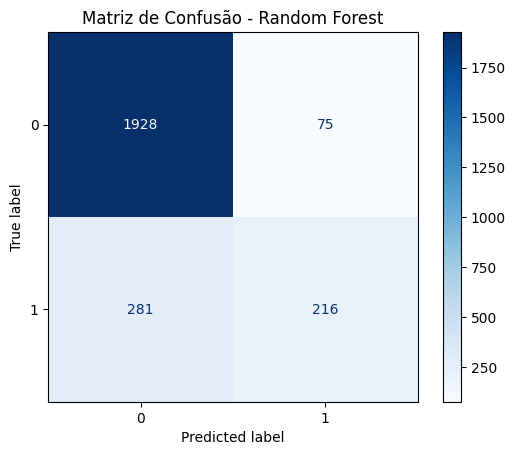

In [56]:
plot_confusion_matrix(y_test, result_rf["y_pred_test"], model_name="Random Forest")

## 6.2 Logistic Regression

In [57]:
lr = LogisticRegression(random_state=42, max_iter=1000)
result_lr = train_and_evaluate(lr, X_train, y_train, X_test, y_test)
print("Logistic Regression - Métricas treino:", result_lr["metrics_train"])
print("Logistic Regression - Métricas teste:", result_lr["metrics_test"])

Logistic Regression - Métricas treino: {'precision': 0.6039119804400978, 'recall': 0.1603896103896104, 'accuracy': 0.806, 'f1': 0.2534633145202668}
Logistic Regression - Métricas teste: {'precision': 0.5407407407407407, 'recall': 0.14688128772635814, 'accuracy': 0.8056, 'f1': 0.2310126582278481}


c:\Users\thales.pinto\Documents\projetos\pessoal\churn\env\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


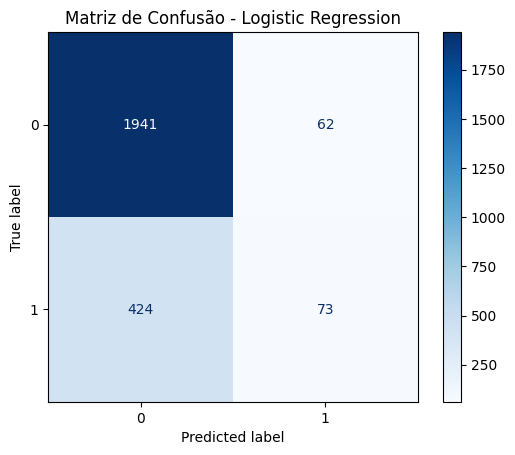

In [58]:
plot_confusion_matrix(y_test, result_lr["y_pred_test"], model_name="Logistic Regression")

'LogisticRegression'

# Tracking de Modelos

In [29]:
track_model(result_rf, model_name=f"{type(rf).__name__}_{ciclo}")

track_model(result_lr, model_name=f"{type(lr).__name__}_{ciclo}")

Tracking done for RandomForestClassifier_Ciclo1
🏃 View run RandomForestClassifier_Ciclo1 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/e36c6ad36996481788fa679f21be798d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
Tracking done for LogisticRegression_Ciclo1
🏃 View run LogisticRegression_Ciclo1 at: http://127.0.0.1:5000/#/experiments/207252348785056863/runs/79a9dcae6aee4c1c803a3a14467b7d47
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/207252348785056863
